## Looking at the Impact of Weather on Individual Plants

In [1]:
import pandas 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import requests
import gzip
import re
from datetime import datetime 

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.metrics import r2_score

Get plant data from egrid file. Save to a csv so I don't need to run this everytime

In [5]:
# # Get plant data for 2014
# egrid_fname = '/home/amy/simple_dispatch/egrid2014_data.xlsx' 
# df_plnt = pandas.read_excel(egrid_fname, 'PLNT14', skiprows=[0])

# #geography
# df_plnt = df_plnt[['ORISPL', 'BACODE', 'ISORTO', 'SUBRGN', 'LAT', 'LON', 'PLFUELCT']]
# df_plnt.columns = ['orispl', 'ba', 'isorto', 'egrid', 'lat', 'lon', 'fuel']

# df_plnt = df_plnt.loc[df_plnt['isorto'] == 'PJM']
# df_plnt.to_csv('df_plnt.csv')

# df_plnt 

In [2]:
df_plnt = pandas.read_csv('df_plnt.csv', index_col=0)
df_plnt.head()

,orispl,ba,isorto,egrid,lat,lon,fuel
2023,59012,PJM,PJM,RFCE,38.820556,-77.018333,BIOMASS
2024,57788,PJM,PJM,RFCE,38.885709,-77.028373,GAS
2025,56430,PJM,PJM,RFCE,39.033900,-75.723300,BIOMASS
2026,56429,PJM,PJM,RFCE,38.599200,-75.434200,BIOMASS
2027,58110,PJM,PJM,RFCE,39.668889,-75.716111,GAS


In [3]:
# Get data for 4 years for North Carolina 
df_data = pandas.DataFrame()
for year in range(2012, 2014):
    print(year)
    cems_folder = '/home/amy/MEFR/Marginal emissions factor data/CEMS/unzipped/' + str(year) + '/'
    s = 'wv'
    df_cems = pandas.DataFrame()

    for m in ['01','02','03','04','05','06','07','08','09','10','11', '12']:
        df_cems_add = pandas.read_csv(cems_folder + str(year) + s + m + '.csv')
        df_cems_add = df_cems_add[['ORISPL_CODE', 'UNITID', 'OP_DATE','OP_HOUR','GLOAD (MW)', 'SO2_MASS (lbs)', 'NOX_MASS (lbs)', 'CO2_MASS (tons)', 'HEAT_INPUT (mmBtu)']].dropna()
        df_cems_add.columns=['orispl', 'unit', 'date','hour','mwh', 'so2_tot', 'nox_tot', 'co2_tot', 'mmbtu']
        df_cems = pandas.concat([df_cems, df_cems_add])

    #create the 'orispl_unit' column, which combines orispl and unit into a unique tag for each generation unit
    df_cems['orispl_unit'] = df_cems['orispl'].map(str) + '_' + df_cems['unit'].map(str)

    df_cems = df_cems.merge(df_plnt, how='left', on='orispl')  
    df_cems = df_cems[df_cems['isorto']=='PJM'] 

    #convert emissions to kg
    df_cems.co2_tot = df_cems.co2_tot * 907.185 #tons to kg
    df_cems.so2_tot = df_cems.so2_tot * 0.454 #lbs to kg
    df_cems.nox_tot = df_cems.nox_tot * 0.454 #lbs to kg

    #calculate the hourly heat and emissions rates. Later we will take the medians over each week to define the generators weekly heat and emissions rates.
    df_cems['heat_rate'] = df_cems.mmbtu / df_cems.mwh
    df_cems['co2'] = df_cems.co2_tot / df_cems.mwh
    df_cems['so2'] = df_cems.so2_tot / df_cems.mwh
    df_cems['nox'] = df_cems.nox_tot / df_cems.mwh
    df_cems.replace([scipy.inf, -scipy.inf], scipy.nan, inplace=True) #don't want inf messing up median calculations

    #drop any bogus data. For example, the smallest mmbtu we would expect to see is 25MW(smallest unit) * 0.4(smallest minimum output) * 6.0 (smallest heat rate) = 60 mmbtu. Any entries with less than 60 mmbtu fuel or less than 6.0 heat rate, let's get rid of that row of data.
    df_cems = df_cems[(df_cems.heat_rate >= 6.0) & (df_cems.mmbtu >= 60)]
    df_data = df_data.append(df_cems)

2012
2013


In [4]:
# Remove outlier heat rates
df_data = df_data[(df_data.mwh >= 10.0) & (df_data.heat_rate <= 30.0)] 

**Get a list of all relevant weather stations**

In [5]:
# Keep ones that are in the U.S. 
df_stations = pandas.read_csv('/home/amy/thesis/temperature/gsod-stations.csv')
df_stations = df_stations.dropna()
df_stations = df_stations.loc[df_stations['CTRY'] == "US"]

# Keep only stations that have data from 2012 - 2018
df_stations['BEGIN']= pandas.to_datetime(df_stations['BEGIN'], format="%Y%m%d") 
df_stations['END']= pandas.to_datetime(df_stations['END'], format="%Y%m%d") 
df_stations = df_stations[(df_stations['BEGIN'] <= '2012-1-1') & (df_stations['END'] >= '2012-12-31')]
df_stations.columns=['USAF', 'WBAN', 'name','country','state', 'ICAO', 'lat', 'lon', 'elev', 'begin', 'end']

df_stations.head()

,USAF,WBAN,name,country,state,ICAO,lat,lon,elev,begin,end
14474,690150,93121,TWENTY NINE PALMS,US,CA,KNXP,34.300,-116.167,625.1,1990-01-02,2020-03-02
15082,700001,26492,PORTAGE GLACIER,US,AK,PATO,60.785,-148.839,31.4,2006-01-01,2020-03-02
15084,700197,26558,SELAWIK,US,AK,PASK,66.600,-159.986,7.6,2006-01-01,2020-03-02
15086,700260,27502,W POST-WILL ROGERS MEMORIAL AIRPORT,US,AK,PABR,71.283,-156.782,9.5,1945-01-01,2020-03-02
15090,700300,27503,WAINWRIGHT AIRPORT,US,AK,PAWI,70.639,-159.995,9.1,1999-11-02,2020-03-02


**Match weather stations with egrid plant data**

In [7]:
df_cems_rounded = df_data.round()
df_stations_rounded = df_stations.round()
df_stations_rounded = df_stations_rounded.drop_duplicates(subset=['lat', 'lon'])

merged = pandas.merge(df_cems_rounded, df_stations_rounded, on=['lat','lon'], how='left', indicator='Exist')
print(merged['Exist'].value_counts(normalize=True) * 100)

# Drop ones that are only in one df, then use the station 
merged = merged.dropna()

both          100.0
right_only      0.0
left_only       0.0
Name: Exist, dtype: float64


In [8]:
# Reformat df to correspond to file storage in ftp 
df_stations.WBAN = df_stations.WBAN.astype(int)
df_stations.WBAN = df_stations.WBAN.astype(str)
df_stations.WBAN = df_stations.WBAN.str.zfill(5)

df_stations['station_id'] = df_stations.USAF + '-' + df_stations.WBAN

df_stations.head()

,USAF,WBAN,name,country,state,ICAO,lat,lon,elev,begin,end,station_id
14474,690150,93121,TWENTY NINE PALMS,US,CA,KNXP,34.300,-116.167,625.1,1990-01-02,2020-03-02,690150-93121
15082,700001,26492,PORTAGE GLACIER,US,AK,PATO,60.785,-148.839,31.4,2006-01-01,2020-03-02,700001-26492
15084,700197,26558,SELAWIK,US,AK,PASK,66.600,-159.986,7.6,2006-01-01,2020-03-02,700197-26558
15086,700260,27502,W POST-WILL ROGERS MEMORIAL AIRPORT,US,AK,PABR,71.283,-156.782,9.5,1945-01-01,2020-03-02,700260-27502
15090,700300,27503,WAINWRIGHT AIRPORT,US,AK,PAWI,70.639,-159.995,9.1,1999-11-02,2020-03-02,700300-27503


**Try using Plant: 3935_1 (coal) and Weather station: 720160-63884**
- Checked the location manually, they are pretty close

In [9]:
### Function from https://github.com/tagomatech/ETL/blob/master/gsod/gsod.py 
def getData(station, year):
    '''
    Get weather data from the internet as memory stream
    '''
    big_df = pandas.DataFrame()


    # Define URL
    url = 'http://www1.ncdc.noaa.gov/pub/data/gsod/' + str(year) + '/' + str(station) \
        + '-' + str(year) + '.op.gz'

    # Define data stream
    stream = requests.get(url)

    # Unzip on-the-fly
    decomp_bytes = gzip.decompress(stream.content)
    data = decomp_bytes.decode('utf-8').split('\n')

    '''
    Data manipulations and ordering
    '''
    # Remove start and end
    data.pop(0) # Remove first line header
    data.pop()  # Remove last element

    # Define lists
    (stn, wban, date, temp, temp_c, dewp, dewp_c,
     slp, slp_c, stp, stp_c, visib, visib_c,
     wdsp, wdsp_c, mxspd, gust, max, max_f, min, min_f,
     prcp, prcp_f, sndp, f, r, s, h, th, tr) = ([] for i in range(30))

    # Fill in lists
    for i in range(0, len(data)):
        stn.append(data[i][0:6])
        wban.append(data[i][7:12])
        date.append(data[i][14:22])         
        temp.append(data[i][25:30])
        dewp.append(data[i][36:41])
        slp.append(data[i][46:52])      # Mean sea level pressure
        stp.append(data[i][57:63])      # Mean station pressure
        visib.append(data[i][68:73])
        wdsp.append(data[i][78:83])
        mxspd.append(data[i][88:93])
        gust.append(data[i][95:100])
        max.append(data[i][103:108])
        min.append(data[i][111:116])
        prcp.append(data[i][118:123])
        sndp.append(data[i][125:130])   # Snow depth in inches to tenth
        f.append(data[i][132])          # Fog
        r.append(data[i][133])          # Rain or drizzle
        s.append(data[i][134])          # Snow or ice pallet
        h.append(data[i][135])          # Hail
        th.append(data[i][136])         # Thunder
        tr.append(data[i][137])         # Tornado or funnel cloud

    '''
    Replacements
    min_f & max_f
    blank   : explicit => e
    *       : derived => d
    '''
    #Create dataframe & cleanse data
    # Create intermediate matrix
    mat = np.matrix(data=[stn, wban, date, temp, dewp,
           slp, stp, visib,
           wdsp, mxspd, gust, max, min,
           prcp, sndp, f, r, s, h, th, tr]).T

    # Define header names
    headers = ['stn', 'wban', 'date', 'temp', 'dewp', 
    'slp', 'stp',  'visib', 
    'wdsp', 'mxspd', 'gust', 'max', 'min', 
    'prcp', 'sndp', 'f', 'r', 's', 'h', 'th', 'tr']

    # Set precision
    pandas.set_option('precision', 3)

    # Create dataframe from matrix object
    df = pandas.DataFrame(data=mat, columns=headers)

    # Replace missing values with NAs
    df = df.where(df != ' ', 9999.9)

    # Create station ids
    df['station_id'] = df['stn'].map(str) + '-' + df['wban'].map(str)
    df = df.drop(['stn', 'wban'], axis=1)

    # Convert to numeric
    df[['temp', 'dewp', 'slp', 'stp', 'visib', 'wdsp','mxspd',  'gust', 'max', 'min', 'prcp', 'sndp']] = df[['temp', 'dewp', 'slp', 'stp', 'visib', 'wdsp', 'mxspd', 'gust', 'max','min', 'prcp', 'sndp']].apply(pandas.to_numeric)
    
    # Replace missing weather data with NaNs
    df = df.replace(to_replace=[99.99, 99.9,999.9,9999.9], value=np.nan)

    # Convert to date format
    df['date'] = pandas.to_datetime(df['date'], format='%Y%m%d')

    big_df = pandas.concat([big_df, df])

    return big_df

In [10]:
weather_data = pandas.DataFrame()

for year in range(2012, 2014):
    print(year)
    try:
        weather_data = weather_data.append(getData(station=str('720160-63884'), year=str(year)))
    except:
        print('no data')
        pass
weather_data

2012
2013


,date,temp,dewp,slp,stp,visib,wdsp,mxspd,gust,max,min,prcp,sndp,f,r,s,h,th,tr,station_id
0,2012-01-01,39.3,37.3,NaN,NaN,9.3,0.9,9.9,21.0,57.2,32.0,NaN,NaN,0,1,0,0,0,0,720160-63884
1,2012-01-02,34.5,22.3,NaN,NaN,9.2,4.8,9.9,22.9,44.6,26.6,NaN,NaN,0,0,1,0,0,0,720160-63884
2,2012-01-03,22.5,17.1,NaN,NaN,5.6,3.2,8.0,15.9,24.8,21.2,NaN,NaN,0,0,1,0,0,0,720160-63884
3,2012-01-04,23.3,15.3,NaN,NaN,10.0,0.2,4.1,NaN,42.8,12.2,0.0,NaN,0,0,0,0,0,0,720160-63884
4,2012-01-05,34.3,28.4,NaN,NaN,10.0,0.3,4.1,NaN,46.4,26.6,0.0,NaN,0,0,0,0,0,0,720160-63884
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,2013-04-26,50.4,35.0,NaN,NaN,10.0,NaN,NaN,NaN,68.0,33.8,0.0,NaN,0,0,0,0,0,0,720160-63884
116,2013-04-27,57.4,43.7,NaN,NaN,10.0,NaN,NaN,NaN,68.2,47.3,NaN,NaN,0,1,0,0,0,0,720160-63884
117,2013-04-28,58.1,53.4,NaN,NaN,9.0,NaN,NaN,NaN,66.9,53.4,NaN,NaN,0,1,0,0,0,0,720160-63884
118,2013-04-29,59.1,54.6,NaN,NaN,9.3,NaN,NaN,NaN,68.0,53.6,NaN,NaN,0,1,0,0,0,0,720160-63884


In [14]:
plant = df_data[df_data['orispl_unit']=='3935_1'] 
cols = ['date', 'hour', 'mwh', 'heat_rate', 'co2', 'so2', 'nox', 'orispl_unit']
plant = plant[cols]
plant['date'] = pandas.to_datetime(plant['date'])

# separate the dfs
demand = plant[['date', 'mwh']]
plant_info = plant[['date', 'mwh', 'heat_rate', 'co2', 'so2', 'nox']]
demand['date'] = pandas.to_datetime(demand['date'])
plant_info['date'] = pandas.to_datetime(plant_info['date'])

# Aggregate by day: sum the demand, average the heat and emissions rates 
demand = demand.groupby('date').sum().reset_index()
plant_info = plant_info.groupby('date').mean().reset_index()

df = pandas.merge(weather_data, demand, on='date', how='left')
df = pandas.merge(weather_data, plant_info, on='date', how='inner')
df

/home/amy/.local/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/home/amy/.local/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


,date,temp,dewp,slp,stp,visib,wdsp,mxspd,gust,max,...,s,h,th,tr,station_id,mwh,heat_rate,co2,so2,nox
0,2012-01-01,39.3,37.3,NaN,NaN,9.3,0.9,9.9,21.0,57.2,...,0,0,0,0,720160-63884,510.083,9.060,861.985,0.020,0.194
1,2012-01-02,34.5,22.3,NaN,NaN,9.2,4.8,9.9,22.9,44.6,...,1,0,0,0,720160-63884,631.125,8.774,834.792,0.088,0.184
2,2012-01-03,22.5,17.1,NaN,NaN,5.6,3.2,8.0,15.9,24.8,...,1,0,0,0,720160-63884,741.167,8.584,816.715,0.157,0.166
3,2012-01-04,23.3,15.3,NaN,NaN,10.0,0.2,4.1,NaN,42.8,...,0,0,0,0,720160-63884,722.167,8.582,816.562,0.139,0.172
4,2012-01-05,34.3,28.4,NaN,NaN,10.0,0.3,4.1,NaN,46.4,...,0,0,0,0,720160-63884,668.833,8.699,827.682,0.126,0.180
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
358,2013-04-26,50.4,35.0,NaN,NaN,10.0,NaN,NaN,NaN,68.0,...,0,0,0,0,720160-63884,796.417,8.672,825.072,0.291,0.187
359,2013-04-27,57.4,43.7,NaN,NaN,10.0,NaN,NaN,NaN,68.2,...,0,0,0,0,720160-63884,707.167,8.693,827.070,0.284,0.184
360,2013-04-28,58.1,53.4,NaN,NaN,9.0,NaN,NaN,NaN,66.9,...,0,0,0,0,720160-63884,731.417,8.621,820.210,0.302,0.199
361,2013-04-29,59.1,54.6,NaN,NaN,9.3,NaN,NaN,NaN,68.0,...,0,0,0,0,720160-63884,765.833,8.650,823.033,0.336,0.203


In [15]:
# Remove columns with a lot of NaN
df = df.drop(columns = ['slp', 'stp', 'prcp', 'sndp', 'gust', 'th', 'tr', 'h', 'f'])

# Replace Nan with mean 
df = df.fillna(df.mean())

# Extract month, hour, and day from date columns
df['month'] = pandas.DatetimeIndex(df.date).month 
df['day'] = pandas.DatetimeIndex(df.date).day
df['year'] = pandas.DatetimeIndex(df.date).year

df

,date,temp,dewp,visib,wdsp,mxspd,max,min,r,s,station_id,mwh,heat_rate,co2,so2,nox,month,day,year
0,2012-01-01,39.3,37.3,9.3,0.900,9.900,57.2,32.0,1,0,720160-63884,510.083,9.060,861.985,0.020,0.194,1,1,2012
1,2012-01-02,34.5,22.3,9.2,4.800,9.900,44.6,26.6,0,1,720160-63884,631.125,8.774,834.792,0.088,0.184,1,2,2012
2,2012-01-03,22.5,17.1,5.6,3.200,8.000,24.8,21.2,0,1,720160-63884,741.167,8.584,816.715,0.157,0.166,1,3,2012
3,2012-01-04,23.3,15.3,10.0,0.200,4.100,42.8,12.2,0,0,720160-63884,722.167,8.582,816.562,0.139,0.172,1,4,2012
4,2012-01-05,34.3,28.4,10.0,0.300,4.100,46.4,26.6,0,0,720160-63884,668.833,8.699,827.682,0.126,0.180,1,5,2012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
358,2013-04-26,50.4,35.0,10.0,1.072,6.085,68.0,33.8,0,0,720160-63884,796.417,8.672,825.072,0.291,0.187,4,26,2013
359,2013-04-27,57.4,43.7,10.0,1.072,6.085,68.2,47.3,1,0,720160-63884,707.167,8.693,827.070,0.284,0.184,4,27,2013
360,2013-04-28,58.1,53.4,9.0,1.072,6.085,66.9,53.4,1,0,720160-63884,731.417,8.621,820.210,0.302,0.199,4,28,2013
361,2013-04-29,59.1,54.6,9.3,1.072,6.085,68.0,53.6,1,0,720160-63884,765.833,8.650,823.033,0.336,0.203,4,29,2013


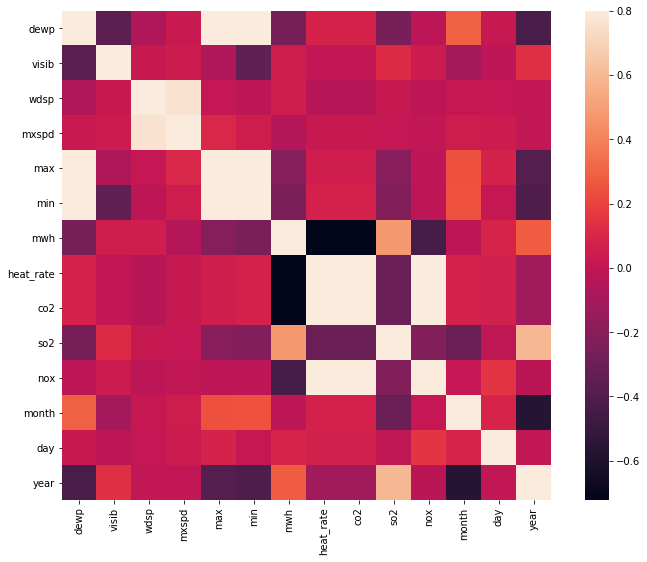

In [18]:
df = df.drop(columns=['date', 'station_id'])

# Remove temperature to keep max and min temp 
df = df.drop(columns=['temp'])

corrmat = df.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

### Heat Rate and Weather

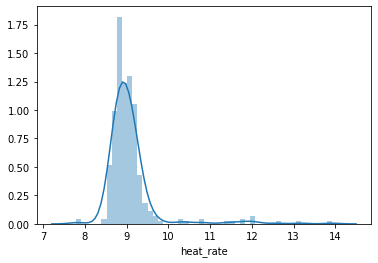

In [16]:
sns.distplot(df['heat_rate'])

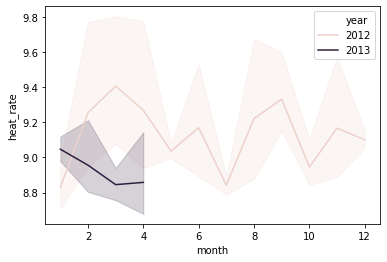

In [17]:
sns.lineplot(x="month", y="heat_rate", hue="year", data=df)

plt.show()

In [21]:
x = df.iloc[:,0:9]
x['month'] = df.month
x['day'] = df.day
x['year'] = df.year
y = df['heat_rate']

# sin/cos correct of month and hour 
x['cos_month'] = np.cos((x.month)*(2*np.pi/12))
x['sin_month'] = np.sin((x.month)*(2*np.pi/12))
x['cos_day'] = np.cos((x.day)*(2*np.pi/12))
x['sin_day'] = np.sin((x.day)*(2*np.pi/12))
x = x.drop(columns=['month', 'day'])

x.head()

,dewp,visib,wdsp,mxspd,max,min,r,s,mwh,year,cos_month,sin_month,cos_day,sin_day
0,37.3,9.3,0.9,9.9,57.2,32.0,1,0,510.083,2012,0.866,0.5,8.660e-01,0.500
1,22.3,9.2,4.8,9.9,44.6,26.6,0,1,631.125,2012,0.866,0.5,5.000e-01,0.866
2,17.1,5.6,3.2,8.0,24.8,21.2,0,1,741.167,2012,0.866,0.5,6.123e-17,1.000
3,15.3,10.0,0.2,4.1,42.8,12.2,0,0,722.167,2012,0.866,0.5,-5.000e-01,0.866
4,28.4,10.0,0.3,4.1,46.4,26.6,0,0,668.833,2012,0.866,0.5,-8.660e-01,0.500


In [22]:
X_train,X_test,y_train,y_test = train_test_split(x,y,test_size = 0.2,random_state = 100) 

lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [23]:
# Define error measure for official scoring : RMSE
scorer = make_scorer(mean_squared_error, greater_is_better = False)

def rmse_cv_train(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring = scorer, cv = 10))
    return(rmse)

def rmse_cv_test(model):
    rmse= np.sqrt(-cross_val_score(model, X_test, y_test, scoring = scorer, cv = 10))
    return(rmse)

In [24]:
print("RMSE on Training set")
print(rmse_cv_train(lr).mean())
print("\n")

print("RMSE on Test set")
print(rmse_cv_test(lr).mean())

RMSE on Training set
0.41099415720252813


RMSE on Test set
0.5440986585818528


In [25]:
# Make predictions using the testing set
results = pandas.DataFrame(index = X_test.index)
results['heat_rate_predicted'] = lr.predict(X_test)
results['heat_rate_actual'] = y_test
results.head()

,heat_rate_predicted,heat_rate_actual
75,9.019,9.025
291,9.430,9.101
276,9.280,9.222
282,9.323,9.118
310,9.195,9.394


In [26]:
y_test.describe()

count    73.000
mean      9.154
std       0.773
min       8.582
25%       8.824
50%       8.979
75%       9.194
max      13.921
Name: heat_rate, dtype: float64

Note: Weather doesn't seem to be heavily correlated, although generation (mwh) is

In [27]:
r2_score(results['heat_rate_actual'], results['heat_rate_predicted'])

0.576277397166717

### CO2 Emission Rates and Weather

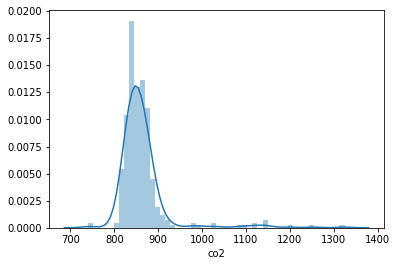

In [28]:
sns.distplot(df['co2'])

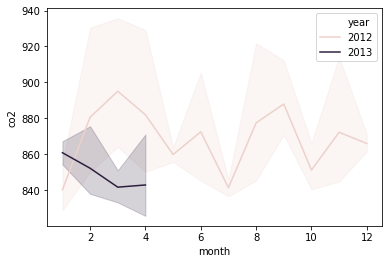

In [29]:
sns.lineplot(x="month", y="co2", hue="year", data=df)

plt.show()

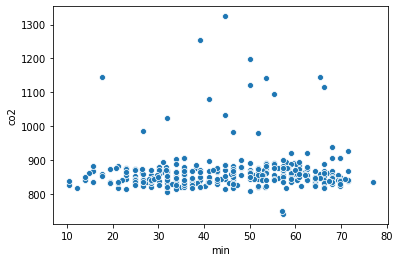

In [30]:
sns.scatterplot(x="min", y="co2", data=df)

plt.show()

In [31]:
y_co2 = df['co2']

In [32]:
X_train,X_test,y_train,y_test = train_test_split(x,y_co2,test_size = 0.2,random_state = 100) 

lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [33]:
print("RMSE on Training set")
print(rmse_cv_train(lr).mean())
print("\n")

print("RMSE on Test set")
print(rmse_cv_test(lr).mean())

RMSE on Training set
39.10387529629868


RMSE on Test set
51.77902158440314


In [34]:
# Make predictions using the testing set
results = pandas.DataFrame(index = X_test.index)
results['co2_predicted'] = lr.predict(X_test)
results['co2_actual'] = y_test
results

,co2_predicted,co2_actual
75,858.109,858.663
291,897.270,865.976
276,882.985,877.396
282,887.013,867.544
310,874.878,893.790
...,...,...
189,835.710,822.349
218,804.748,821.844
3,837.211,816.562
254,869.839,876.067


In [35]:
y_test.describe()

count      73.000
mean      870.925
std        73.584
min       816.562
25%       839.565
50%       854.268
75%       874.745
max      1324.737
Name: co2, dtype: float64

In [36]:
r2_score(results['co2_actual'], results['co2_predicted'])

0.5761940816313267